# Tutorial 1 Appendix: Using MPI with the Poisson example 
This notebook serves to outline the code structure in order to use MPI for parallel sampling in the risk measure computation. 
We will use the same problem setup as in tutorial 1, the optimal control of a Poisson equation with log-normal coefficient field. 

The notebook itself will only run in serial, but it highlights the changes from the code from tutorial 1 to that will enable parallel sampling. 
Instead, export this notebook as a python script. Then, for example, executing
```
mpirun -n 4 python name_of_exported_script.py
```
will run the code with 4 processes. 


Alternatively, a standalone python script implementing a similar example is available in `examples/poisson/driver_poisson_mean.py`.


## Using MPI for parallel sampling with FEniCS 

By default, FEniCS uses MPI to discretize and solve the PDE problems in parallel by partitioning the mesh and its corresponding degrees of freedom. 
The `MPI.COMM_WORLD` communicator will be used by default when instantiating a mesh object, which will be partitioned based on the communicator. 
Subsequent objects such as function spaces, functions, vectors, created from the mesh will also inherit this communicator, and be partitioned based on the mesh. 

In the current implementation of SOUPy, either mesh parallelism or sample parallelism is supported (but simultaneously both, yet). Sample parallelism is preferred if memory is not a concern as the sampling part is inherently parallel.

In order to use sample parallelism instead of mesh parallelism, the user needs to supply a MPI communicator to the mesh that is of size 1. This will prevent FEniCS from partitioning the mesh. The risk measure classes in SOUPy then take a sampling MPI communicator that will handle the sample partitioning (i.e. with all the processors). 

The simplest way to do this is to use `MPI.COMM_SELF` for the mesh and `MPI.COMM_WORLD` for the sampling.


## 1. Import libraries 
Note: hippylib and soupy paths need to be appended if cloning the repos instead of installing via pip

In [1]:
import sys 
import os 
sys.path.append(os.environ.get('HIPPYLIB_PATH')) # Needed if using cloned repo
sys.path.append(os.environ.get('SOUPY_PATH')) # Needed if using cloned repo
import time

import numpy as np 
import matplotlib.pyplot as plt 
import dolfin as dl 
import hippylib as hp 
from mpi4py import MPI 

import soupy 

## 2. Setup the function space
The setup is basically the same as before, except we start by defining the communicators using
`MPI.COMM_SELF` for the mesh and `MPI.COMM_WORLD` for sampling.

The mesh communicator is passed to the mesh constructor. Subsequent objects created from the mesh will inherit the communicator and will not be partitioned.

In [2]:
N_ELEMENTS_X = 20
N_ELEMENTS_Y = 20

comm_mesh = MPI.COMM_SELF
comm_sampler = MPI.COMM_WORLD

mesh = dl.UnitSquareMesh(comm_mesh, N_ELEMENTS_X, N_ELEMENTS_Y) # Using MPI.COMM_SELF for the mesh so it does not partition

Vh_STATE = dl.FunctionSpace(mesh, "CG", 1)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh_CONTROL = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE, Vh_CONTROL] 

## 3. Define the PDE problem, prior, QoI, and control model
This part is largely the same before, but note that any FEniCS objects not directly created from the function space/mesh (e.g. expressions, standalone vectors, matrices, etc.) should be explicitly handed the mesh communicator, as otherwise they will use the `COMM_WORLD` by default. 
These objects will accept an optional input of `mpi_comm`. 

In [3]:
# Define PDE 

def residual(u,m,v,z):
    return dl.exp(m)*dl.inner(dl.grad(u), dl.grad(v))*dl.dx - z * v *dl.dx 

def boundary(x, on_boundary):
    return on_boundary and (dl.near(x[1], 0) or dl.near(x[1], 1))

boundary_value = dl.Expression("x[1]", degree=1, mpi_comm=comm_mesh) # Need to use the same mpi_comm as the mesh

bc = dl.DirichletBC(Vh_STATE, boundary_value, boundary)
bc0 = dl.DirichletBC(Vh_STATE, dl.Constant(0.0), boundary)
pde = soupy.PDEVariationalControlProblem(Vh, residual, [bc], [bc0], is_fwd_linear=True)

# Define prior
PRIOR_GAMMA = 0.5
PRIOR_DELTA = 10.0
PRIOR_MEAN = -3.0

mean_vector = dl.interpolate(dl.Constant(PRIOR_MEAN), Vh_PARAMETER).vector()
prior = hp.BiLaplacianPrior(Vh_PARAMETER, PRIOR_GAMMA, PRIOR_DELTA, mean=mean_vector, robin_bc=False)

# Define QoI
u_target = dl.Expression("x[1] + sin(k*x[1]) * cos(k*x[0])", k=2*np.pi, degree=2, mpi_comm=comm_mesh) # Need to use the same mpi_comm as the mesh

def l2_qoi_form(u,m,z):
    return (u - u_target)**2 * dl.dx 

qoi = soupy.VariationalControlQoI(Vh, l2_qoi_form)

# Combine into control model
control_model = soupy.ControlModel(pde, qoi)

## 4. Define the risk measure with the sample communicator
The SAA risk measures in SOUPy take an optional `comm_sampler` argument. Hand it the `comm_sampler` we have created. 
Currently, the parallel sampling for risk measures is configured in a way such that it will use the same set of samples as the serial case when using the same input RNG seed. This is useful for the purpose of creating benchmarks/baselines for research.

In [4]:
VARIANCE_WEIGHT = 0.0
SAMPLE_SIZE = 10
RANDOM_SEED = 1

risk_settings = soupy.meanVarRiskMeasureSAASettings()
risk_settings["beta"] = VARIANCE_WEIGHT
risk_settings["sample_size"] = SAMPLE_SIZE 
risk_settings["seed"] = RANDOM_SEED
risk_measure = soupy.MeanVarRiskMeasureSAA(control_model, prior, risk_settings, comm_sampler=comm_sampler)

## 5. Define the penalization and assemble the cost
This is the same as in the serial code. Take care to hand any `dolfin.Expression` objects the `comm_mesh` communicator. 

In [5]:
PENALTY_WEIGHT = 1e-3
def l2_penalization_form(z):
    return dl.Constant(PENALTY_WEIGHT) * z**2 * dl.dx 

penalty = soupy.VariationalPenalization(Vh, l2_penalization_form)

cost_functional = soupy.RiskMeasureControlCostFunctional(risk_measure, penalty)

## 6. Optimization 
The optimization algorithms in SOUPy will execute with either sample or mesh parallelism, and is called as usual. 

Though not described in this notebook, either sampler or mesh parallelism will also work with SciPy optimization algorithms using the SOUPy interface.

In [6]:
optimizer = soupy.InexactNewtonCG(cost_functional)
z = cost_functional.generate_vector(soupy.CONTROL)

t0 = time.time()
optimizer.solve(z)
t1 = time.time()

print("Proc %d: Optimization took %f seconds" % (comm_sampler.rank, t1-t0))


It  cg_it cost            (g,dz)          ||g||L2         alpha          
  1   2    1.369681e-02   -4.744559e-01    1.181035e-02    1.000000e+00    5.000000e-01
  2   3    1.248531e-02   -2.422989e-03    2.215114e-03    1.000000e+00    4.330785e-01
  3   6    1.205918e-02   -8.522694e-04    4.176918e-04    1.000000e+00    1.880600e-01
  4  23    1.197968e-02   -1.589976e-04    6.301921e-05    1.000000e+00    7.304745e-02
  5  38    1.197905e-02   -1.266265e-06    3.153411e-06    1.000000e+00    1.634025e-02
  6  67    1.197904e-02   -1.108209e-09    4.841012e-08    1.000000e+00    2.024588e-03
Proc 0: Optimization took 57.666618 seconds


## 7. Notes on postprocessing
When using sample parallelism, each process will maintain a local copy of the optimal control in its entirety (i.e. no mesh partitioning).
This is expected to have same degree-of-freedom ordering as in the serial case. 
The solution can be saved as a numpy array using `z.get_local()` and be loaded in serially later.
Alternatively, FEniCS's built in I/O functionalities such as `HDF5File` or `XDMFFile` can also be used, but remember to hand it the `comm_mesh`.

Here in the notebook, we will just plot a sample of the state at the optimal control as in tutorial 1. 

Note that since `noise` is created as a standalone vector, we would usually need to provide it with the mesh communicator.

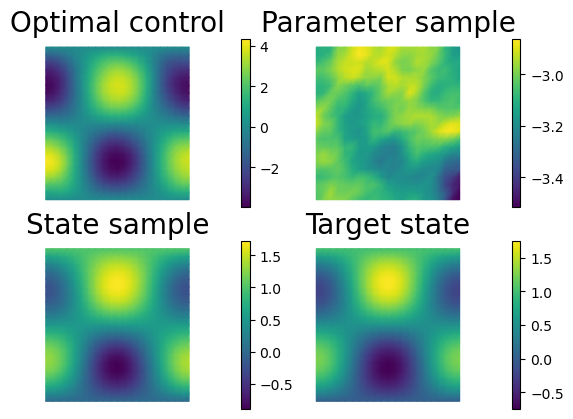

In [7]:
# Initialize vectors for the state, parameter, adjoint (not used) and control variables
x = cost_functional.generate_vector()

# Initialize the noise vector 
noise = dl.Vector(comm_mesh)
prior.init_vector(noise, "noise")

# Use hippylib's rng to sample Gaussian white noise 
rng = hp.Random(seed=111)

# This is sampling noise with 1.0 standard dev to the noise vector
rng.normal(1.0, noise) 

# The prior then turns the noise into a parameter sample
prior.sample(noise, x[soupy.PARAMETER])

# Also set the CONTROL component of x to the optimal control z
x[soupy.CONTROL].axpy(1.0, z)

# Solve the forward problem
control_model.solveFwd(x[soupy.STATE], x)

# Convert to functions and plot
u_fun = dl.Function(Vh[soupy.STATE], x[soupy.STATE])
m_fun = dl.Function(Vh[soupy.PARAMETER], x[soupy.PARAMETER])
z_fun = dl.Function(Vh[soupy.CONTROL], x[soupy.CONTROL])
u_target_fun = dl.interpolate(u_target, Vh[soupy.STATE])

if comm_sampler.rank == 0:
    hp.nb.plot(z_fun, mytitle="Optimal control", subplot_loc=221)
    hp.nb.plot(m_fun, mytitle="Parameter sample", subplot_loc=222)
    hp.nb.plot(u_fun, mytitle="State sample", subplot_loc=223)
    hp.nb.plot(u_target_fun, mytitle="Target state", subplot_loc=224)

plt.show()